In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers

# ------------------------- 1) Load and Preprocess Data -------------------------
file_path = "Processed_CO2_Emissions_Canada.csv"
df = pd.read_csv(file_path)

cat_cols = ["Make", "Model1", "Model2", "Vehicle Class", "Transmission1", "Transmission2", "Fuel Type"]
num_cols = [
    "Engine Size(L)", "Cylinders", "Fuel Consumption City (L/100 km)", 
    "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", 
    "Fuel Consumption Comb (mpg)", "CO2 Emissions(g/km)"
]

df = df[cat_cols + num_cols].dropna().copy()

label_encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    label_encoders[c] = le

cat_cols_for_autoencoder = ["Vehicle Class", "Transmission1", "Transmission2", "Fuel Type"]
X_num = df[num_cols].values.astype("float32")
X_cat = df[cat_cols_for_autoencoder].values.astype("int32")
make_series = df["Make"].copy()

def embedding_dim(n_cat):
    return min(50, (n_cat // 2) + 1)

cat_input_layers, embed_layers = [], []
num_categories = [df[c].nunique() for c in cat_cols_for_autoencoder]

for i, n_cat in enumerate(num_categories):
    input_i = keras.Input(shape=(1,), name=f"cat_in_{i}")
    cat_input_layers.append(input_i)
    embed_i = layers.Embedding(input_dim=n_cat, output_dim=embedding_dim(n_cat))(input_i)
    embed_i = layers.Flatten()(embed_i)
    embed_layers.append(embed_i)

num_input = keras.Input(shape=(len(num_cols),), name="num_in")
x = layers.Concatenate()(embed_layers + [num_input])
x = layers.Dense(32, activation="relu")(x)
latent = layers.Dense(8, activation="relu", name="latent")(x)

x_dec = layers.Dense(32, activation="relu")(latent)
num_out = layers.Dense(len(num_cols), activation="linear", name="num_out")(x_dec)

cat_outs = [layers.Dense(n_cat, activation="softmax", name=f"cat_out_{i}")(x_dec) for i, n_cat in enumerate(num_categories)]

autoencoder = keras.Model(inputs=cat_input_layers + [num_input], outputs=[*cat_outs, num_out])
losses = {f"cat_out_{i}": "sparse_categorical_crossentropy" for i in range(len(cat_cols_for_autoencoder))}
losses["num_out"] = "mse"
autoencoder.compile(optimizer="adam", loss=losses)

X_train_list = [X_cat[:, i] for i in range(len(cat_cols_for_autoencoder))] + [X_num]
y_train_list = [X_cat[:, i] for i in range(len(cat_cols_for_autoencoder))] + [X_num]
autoencoder.fit(X_train_list, y_train_list, epochs=10, batch_size=256, validation_split=0.1, verbose=1)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - cat_out_0_loss: 10.2227 - cat_out_1_loss: 8.1189 - cat_out_2_loss: 5.5069 - cat_out_3_loss: 5.2653 - loss: 9675.7422 - num_out_loss: 9646.5098 - val_cat_out_0_loss: 9.7133 - val_cat_out_1_loss: 5.2305 - val_cat_out_2_loss: 11.6324 - val_cat_out_3_loss: 9.5582 - val_loss: 8052.4546 - val_num_out_loss: 7991.5376
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cat_out_0_loss: 9.0584 - cat_out_1_loss: 4.2834 - cat_out_2_loss: 9.3328 - cat_out_3_loss: 10.6586 - loss: 7329.5366 - num_out_loss: 7296.0054 - val_cat_out_0_loss: 7.0065 - val_cat_out_1_loss: 2.7213 - val_cat_out_2_loss: 10.5547 - val_cat_out_3_loss: 5.9602 - val_loss: 4502.4062 - val_num_out_loss: 4461.2690
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - cat_out_0_loss: 6.2464 - cat_out_1_loss: 2.3343 - cat_out_2_loss: 7.0200 - cat_out_3_loss: 4.4646 - loss: 3355.7629 - num_out_loss: 3335.5085 - val_cat_out_0_loss: 4.0900 - val_cat_out_1_loss: 1.7639 - val_cat_out_2_los

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


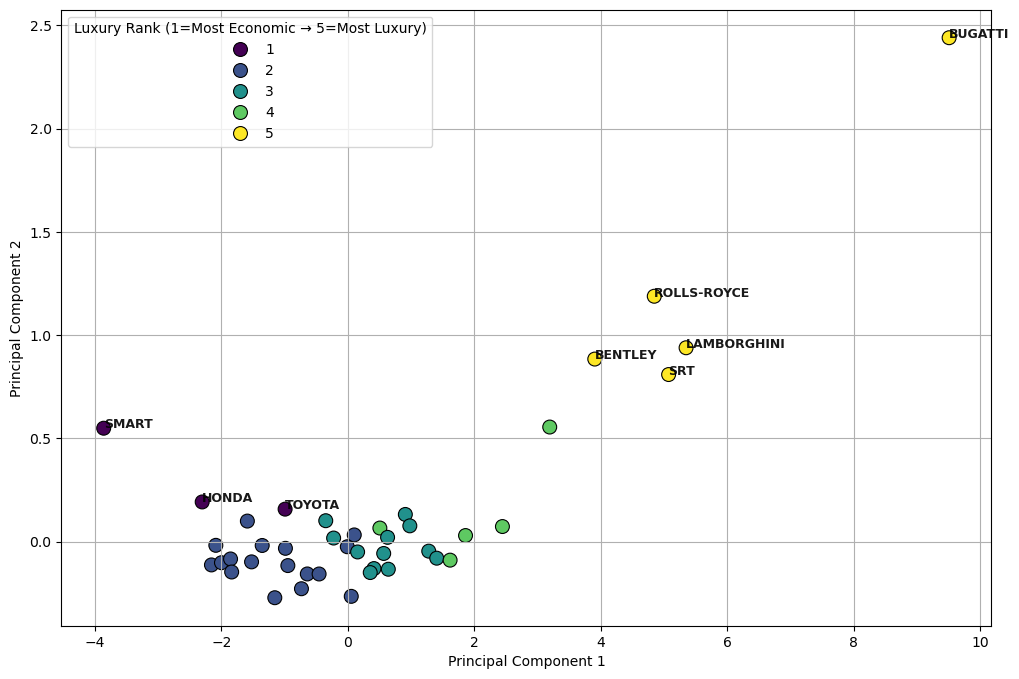

   Cluster_Rank                                  Brands in Cluster
0             1                               HONDA, SMART, TOYOTA
1             2  ACURA, ALFA ROMEO, AUDI, BMW, BUICK, FIAT, HYU...
2             3  CADILLAC, CHRYSLER, DODGE, FORD, INFINITI, JAG...
3             4        ASTON MARTIN, CHEVROLET, GMC, MASERATI, RAM
4             5    BENTLEY, LAMBORGHINI, ROLLS-ROYCE, SRT, BUGATTI


In [44]:
# ------------------------- 2) Clustering -------------------------
encoder = keras.Model(inputs=autoencoder.inputs, outputs=latent)
Z = encoder.predict(X_train_list)
Z_scaled = StandardScaler().fit_transform(Z)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(Z_scaled)
df["Make_Name"] = label_encoders["Make"].inverse_transform(make_series)

# Ensure each brand belongs to only one cluster (most frequent one)
brand_to_cluster = df.groupby("Make_Name")["Cluster"].agg(lambda x: x.mode()[0])
df["Cluster"] = df["Make_Name"].map(brand_to_cluster)

# ------------------------- 5) Rank Clusters by Average CO2 Emissions -------------------------
# Compute average CO2 emissions per cluster
cluster_co2_avg = df.groupby("Cluster")["CO2 Emissions(g/km)"].mean().sort_values()

# Assign ranks based on CO2 emissions (lower emissions = higher rank)
cluster_rank = {cluster: rank for rank, cluster in enumerate(cluster_co2_avg.index, 1)}
df["Cluster_Rank"] = df["Cluster"].map(cluster_rank)

# ------------------------- 6) PCA Visualization with Averaged Brand Positions -------------------------
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(Z_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(Z_pca, columns=["PC1", "PC2"])
df_pca["Make_Name"] = df["Make_Name"]
df_pca["Cluster"] = df["Cluster"]
df_pca["Cluster_Rank"] = df["Cluster"].map(cluster_rank)

# Compute the average PCA position for each brand
df_pca_avg = df_pca.groupby("Make_Name", as_index=False).agg({"PC1": "mean", "PC2": "mean"})

# Assign each brand to its cluster
df_pca_avg["Cluster"] = df_pca_avg["Make_Name"].map(brand_to_cluster)
df_pca_avg["Cluster_Rank"] = df_pca_avg["Cluster"].map(cluster_rank).astype(int)

# Scatter plot with averaged positions
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=df_pca_avg["PC1"], 
    y=df_pca_avg["PC2"], 
    hue=df_pca_avg["Cluster_Rank"], 
    palette="viridis", 
    edgecolor="k",
    s=100  # Larger dots for visibility
)

# Select representative brands: Top luxury & most economic
top_brands = df_pca_avg[df_pca_avg["Cluster_Rank"] == df_pca_avg["Cluster_Rank"].max()]
bottom_brands = df_pca_avg[df_pca_avg["Cluster_Rank"] == df_pca_avg["Cluster_Rank"].min()]
selected_brands = pd.concat([top_brands, bottom_brands])

# Add filtered text labels
for i in range(len(selected_brands)):
    plt.text(
        selected_brands["PC1"].iloc[i],
        selected_brands["PC2"].iloc[i],
        selected_brands["Make_Name"].iloc[i],
        fontsize=9, fontweight="bold", alpha=0.9
    )

# Customize plot
#plt.title("PCA Visualization of Vehicle Clusters (Luxury Ranking - Averaged by Brand)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Luxury Rank (1=Most Economic → 5=Most Luxury)", loc="best")
plt.grid(True)
plt.show()

# Group by ranked Cluster and collect unique brands
cluster_brands = df.groupby("Cluster_Rank")["Make_Name"].unique().reset_index()

# Convert list of brands into a readable string format
cluster_brands["Brands in Cluster"] = cluster_brands["Make_Name"].apply(lambda x: ", ".join(x))

# Drop the original list column for cleaner output
cluster_brands = cluster_brands.drop(columns=["Make_Name"])

# Display the DataFrame
print(cluster_brands)

In [43]:
# Save the full dataframe with all information
df.to_csv("Full_Clustered_Data.csv", index=False)

PermissionError: [Errno 13] Permission denied: 'Full_Clustered_Data.csv'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ----------------------- Step 1: Define Features -----------------------
features = ["Vehicle Class", "Transmission1", "Transmission2", "Fuel Type", "Engine Size(L)", "Cylinders"]
categorical_features = ["Vehicle Class", "Transmission1", "Transmission2", "Fuel Type"]
numerical_features = ["Engine Size(L)", "Cylinders"]
target = "Cluster_Rank"

df=df[features+[target]]

# ----------------------- Step 2: Train-Test Split -----------------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])

# ----------------------- Step 3: K-Fold Target Encoding -----------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_encoded_df = train_df.copy()
for cat in categorical_features:
    train_encoded_df[f"{cat}_encoded"] = np.nan
    for train_idx, val_idx in kf.split(train_df):
        fold_train = train_df.iloc[train_idx]
        target_mean = fold_train.groupby(cat)[target].mean()
        valid_idx = train_encoded_df.index.intersection(val_idx)
        train_encoded_df.loc[valid_idx, f"{cat}_encoded"] = train_df.loc[valid_idx, cat].map(target_mean)
    train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)

# Encode test set using full train mapping
test_encoded_df = test_df.copy()
for cat in categorical_features:
    overall_mapping = train_df.groupby(cat)[target].mean()
    test_encoded_df[f"{cat}_encoded"] = test_df[cat].map(overall_mapping)
    test_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)

# ----------------------- Step 4: Drop Original Categorical Columns -----------------------
train_encoded_df.drop(columns=categorical_features, inplace=True)
test_encoded_df.drop(columns=categorical_features, inplace=True)

# ----------------------- Step 5: Scale Numerical Features -----------------------
scaler = StandardScaler()
train_encoded_df[numerical_features] = scaler.fit_transform(train_encoded_df[numerical_features])
test_encoded_df[numerical_features] = scaler.transform(test_encoded_df[numerical_features])

# ----------------------- Step 6: Prepare Data -----------------------
X_train = train_encoded_df.drop(columns=[target])
y_train = train_encoded_df[target]

X_test = test_encoded_df.drop(columns=[target])
y_test = test_encoded_df[target]

# Step 7: Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Step 8: Predict and Evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14408\1375097368.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14408\1375097368.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

              precision    recall  f1-score   support

           1       0.78      0.76      0.77       335
           2       0.72      0.74      0.73       376
           3       0.87      0.83      0.85       501
           4       0.77      0.83      0.80       237
           5       0.78      0.89      0.83        28

    accuracy                           0.79      1477
   macro avg       0.78      0.81      0.80      1477
weighted avg       0.79      0.79      0.79      1477

